In [1]:
import importlib
import torch
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from PIL import Image

from matplotlib import pyplot as plt
from utils import img, pyramid, stats, hooking

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [2]:
vgg19 = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = vgg19.to(device)
for param in vgg19.features.parameters(): # stop training the net
    param.requires_grad = False

### Normalization

vgg19 expects all inputs to be normalized according to the imagenet input means and standard deviations. Un-normalized inputs will still work, but the results are less visually appealing. To help us normalize inputs we will create a custom `Normalization` layer. Everything we pass to our vgg model will go through this layer first. 

In [4]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
normalization_layer = Normalization(normalization_mean, normalization_std).to(device)

Next we make a new network, using the first 38 layers from our pretrained vgg network. For our purposes we won't need the rest, and removing the fully connected layers near the end means we can work with inputs of varying sizes.  

The first layer in our new network will be our custom normalization layer.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [5]:
useful_layers = list(list(vgg19.children())[0][:13])
useful_layers.insert(0, normalization_layer)

vgg = nn.Sequential(*useful_layers)
print(len(list(vgg.children()))) # should be 14
list(vgg.children())

14


[Normalization(),
 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [ ]:
vgg_layers = list(vgg.children())[0]

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

## Perpairing the example texture

As per the paper, we need some target style statistics in order to generate the style loss for the image we're performing style transfer on. We get these statistics by:

1. Choosing a style image
2. Converting that image into a gaussian pyramid
3. Running each slice of that pyramid through our model, and 
4. Recording the gram matrices of the feature maps output by certain layers for each slice

In the next two cells we will be loading in the style image and creating a pyramid out of it.

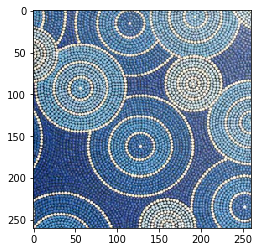

In [19]:
transform = transforms.Compose([
    transforms.CenterCrop(260),
    transforms.ToTensor(),
])

img_path = "data/style/"
img_name = "rings-2.jpg" # we use this variable later
full_path = img_path + img_name

example_texture = img.image_loader(full_path, transform)
img.show_image(example_texture)

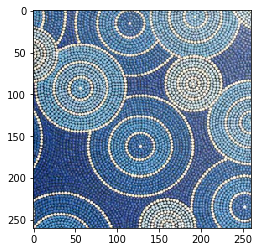

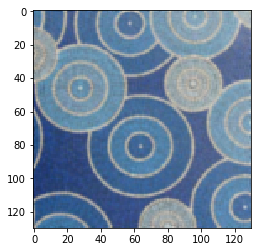

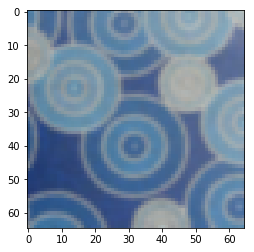

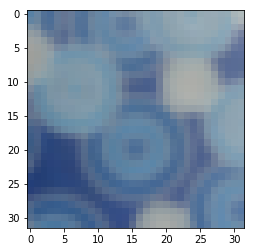

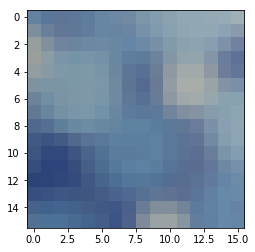

In [20]:
gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)

example_pyr = pyramid.gaussian_pyramid(example_texture, gaussian_kernel, max_levels=4)
for pyr_slice in example_pyr:
    img.show_image(pyr_slice)

Next we attach hooks to the vgg layers whose outputs we will use to generate target statistics from. The paper recommends using the 3rd and 8th layers (only counting conv and pooling layers)

In [1]:
hooks = hooking.attach_hooks(vgg, [4, 13]) 
# the layers reccomended by the xavier's paper, offest because of the normalization layer
print(len(hooks)) # should be 2

NameError: name 'importlib' is not defined

Now we actually generate the target statistics by running every layer in the example pyramid through our network and recording the outputs (actually their gram matrices) of the layers we just hooked. The target statistics will now sit in `example_feature_pyr`

In [ ]:
example_feature_pyr = []

for pyr_slice in example_pyr:
    vgg(pyr_slice)
    slice_stats = [stats.gram_matrix(hook.features) for hook in hooks]
    example_feature_pyr.append(slice_stats)

## Computing Loss

Next we need a way of generating a loss from the target style and content statistics, and some sample statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). 

The paper reccomends using LBFGS to perform gradient updates, so this is what we will use. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html): `torch.optim.LBFGS()` for generating LBFGS optimizers. However, if you're using a `torch.optim.LBFGS()` optimizer as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. 

And unfortunately, we can't pass any arguments to the `closure()` function directly. So, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

Broadly this `GradientStepper` class will:

1. Take in the target style and content statistics plus a sample image 
2. Work out equivelent statistics for the sample image (which involves creating a gaussian pyramid in our case) 
3. Compare these to the targets
4. Calculate a loss from this comparison, and
5. Calculate the gradient of the sample image with respect to that loss

The paper recommends using *mean squared error* to caclulate the losses, so this is what we will use, along with pytrch's autograd.

In [23]:
class GradientStepper():
    gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)
    
    def __init__(self, optimizer, model, sample, example_feature_pyr, hooks, scale):
        self.optimizer = optimizer
        self.sample = sample
        self.example_feature_pyr = example_feature_pyr
        self.model = model
        self.hooks = hooks
        self.scale = scale
        self.losses = []

    def loss_fn(self, sample_feature_pyr):
        loss = 0
        
        for i in range(len(sample_feature_pyr)):
            sample_stats = sample_feature_pyr[i]
            target_stats = self.example_feature_pyr[i]
            
            for j in range(len(sample_stats)):
                loss += torch.mean((sample_stats[j] - target_stats[j]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale
    
    def gaussian_pyramid(self):
        return pyramid.gaussian_pyramid(self.sample, self.gaussian_kernel, max_levels=4)
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 
        
        sample_pyr = self.gaussian_pyramid()
        sample_feature_pyr = []
        
        for sample in sample_pyr:
            self.model(sample)
            sample_feature_pyr.append([stats.gram_matrix(hook.features) for hook in self.hooks])

        loss = self.loss_fn(sample_feature_pyr)
        self.losses.append(loss)
        loss.backward()

        print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


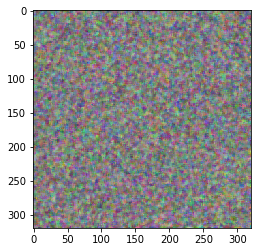

In [24]:
img.show_image(img.random_image(5))

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [25]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["hooks", "model", "iterations", "id"]:
            if key == "name":
                id += params[key].replace(".jpg", "") + "-"
            else:
                id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [26]:
class Synthesizer():
    def __init__(self, params):
        self.saver = img.Saver(params["save_mode"])
        self.example_feature_pyr = params["example_feature_pyr"]
        self.save_at = 1 if params["save_mode"] == "throughout" else 0
    
    def synthesize(self, params):
        if self.save_at == 0:
            self.save_at = params["iterations"]
        
        sample_texture = img.random_image(params["blur"], params["size"])
        optimizer = optim.LBFGS([sample_texture], lr=params["lr"])
        stepper = GradientStepper(optimizer, params["model"], sample_texture, self.example_feature_pyr, params["hooks"], params["scale"])
        
        self.saver.prepair_save_directory(params)

        for i in range (params["iterations"]):
            if sample_texture.grad is not None:
                print(sample_texture.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                self.saver.save_image(sample_texture, self.save_at)
                self.save_at *= 2

                if params["scale_decay"] > 0:
                    stepper.scale -= (stepper.scale / params["scale_decay"])
        
        self.save_at = 0
        return sample_texture, stepper.losses

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

xstd-normalized-rings-2-size250-layers4-blur5-scale_decay0-scale1000000-lr0.1
scale: 1000000
loss: 303247.28125
scale: 1000000
loss: 303241.71875
scale: 1000000
loss: 292923.875
scale: 1000000
loss: 282003.96875
scale: 1000000
loss: 270546.78125
scale: 1000000
loss: 258381.125
scale: 1000000
loss: 245237.5
scale: 1000000
loss: 231296.0625
scale: 1000000
loss: 217524.046875
scale: 1000000
loss: 203303.59375
scale: 1000000
loss: 189338.203125
scale: 1000000
loss: 176387.25
scale: 1000000
loss: 164394.046875
scale: 1000000
loss: 153323.484375
scale: 1000000
loss: 142696.5
scale: 1000000
loss: 133204.078125
scale: 1000000
loss: 123857.96875
scale: 1000000
loss: 115206.1328125
scale: 1000000
loss: 106954.734375
scale: 1000000
loss: 99129.1875
tensor([ 1.1012,  2.3263,  0.5508, -2.4182], device='cuda:0')
scale: 1000000
loss: 91661.9140625
scale: 1000000
loss: 84795.921875
scale: 1000000
loss: 78307.328125
scale: 1000000
loss: 72191.0234375
scale: 1000000
loss: 66335.515625
scale: 1000000
los

scale: 1000000
loss: 1705.88525390625
scale: 1000000
loss: 1700.870361328125
scale: 1000000
loss: 1695.088623046875
scale: 1000000
loss: 1688.2349853515625
scale: 1000000
loss: 1683.2315673828125
scale: 1000000
loss: 1678.6962890625
scale: 1000000
loss: 1673.1907958984375
scale: 1000000
loss: 1667.635009765625
scale: 1000000
loss: 1662.057861328125
scale: 1000000
loss: 1656.4114990234375
scale: 1000000
loss: 1651.1776123046875
scale: 1000000
loss: 1646.8238525390625
scale: 1000000
loss: 1641.3056640625
scale: 1000000
loss: 1637.041015625
scale: 1000000
loss: 1633.4676513671875
scale: 1000000
loss: 1629.1544189453125
tensor([-0.0212, -0.0133, -0.0283, -0.0132], device='cuda:0')
scale: 1000000
loss: 1624.54052734375
scale: 1000000
loss: 1619.8656005859375
scale: 1000000
loss: 1615.356201171875
scale: 1000000
loss: 1611.8304443359375
scale: 1000000
loss: 1608.157470703125
scale: 1000000
loss: 1604.0050048828125
scale: 1000000
loss: 1599.267822265625
scale: 1000000
loss: 1595.2108154296875

loss: 1322.5518798828125
scale: 1000000
loss: 1321.774169921875
scale: 1000000
loss: 1320.948486328125
scale: 1000000
loss: 1320.2030029296875
scale: 1000000
loss: 1319.0115966796875
scale: 1000000
loss: 1318.2918701171875
scale: 1000000
loss: 1317.4761962890625
scale: 1000000
loss: 1316.7677001953125
scale: 1000000
loss: 1316.0404052734375
scale: 1000000
loss: 1315.342041015625
scale: 1000000
loss: 1314.50048828125
scale: 1000000
loss: 1313.70361328125
scale: 1000000
loss: 1312.8468017578125
scale: 1000000
loss: 1312.083740234375
scale: 1000000
loss: 1311.28564453125
scale: 1000000
loss: 1310.5504150390625
scale: 1000000
loss: 1309.72314453125
scale: 1000000
loss: 1308.76171875
tensor([0.0960, 0.0730, 0.0717, 0.0669], device='cuda:0')
scale: 1000000
loss: 1308.0604248046875
scale: 1000000
loss: 1307.2918701171875
scale: 1000000
loss: 1306.6431884765625
scale: 1000000
loss: 1305.8841552734375
scale: 1000000
loss: 1305.053466796875
scale: 1000000
loss: 1304.231689453125
scale: 1000000
l

loss: 1233.0396728515625
tensor([ 0.0107,  0.0057, -0.0016, -0.0022], device='cuda:0')
scale: 1000000
loss: 1232.7489013671875
scale: 1000000
loss: 1232.372314453125
scale: 1000000
loss: 1231.880615234375
scale: 1000000
loss: 1231.4957275390625
scale: 1000000
loss: 1231.0596923828125
scale: 1000000
loss: 1230.5765380859375
scale: 1000000
loss: 1230.1015625
scale: 1000000
loss: 1229.608642578125
scale: 1000000
loss: 1229.2314453125
scale: 1000000
loss: 1228.8505859375
scale: 1000000
loss: 1228.428466796875
scale: 1000000
loss: 1228.039794921875
scale: 1000000
loss: 1227.621337890625
scale: 1000000
loss: 1227.222900390625
scale: 1000000
loss: 1226.8670654296875
scale: 1000000
loss: 1226.3597412109375
scale: 1000000
loss: 1226.0941162109375
scale: 1000000
loss: 1225.6744384765625
scale: 1000000
loss: 1225.36767578125
scale: 1000000
loss: 1225.0733642578125
tensor([0.0688, 0.0567, 0.0417, 0.0312], device='cuda:0')
scale: 1000000
loss: 1224.7806396484375
scale: 1000000
loss: 1224.5131835937

scale: 1000000
loss: 1185.864501953125
scale: 1000000
loss: 1185.75341796875
scale: 1000000
loss: 1185.5849609375
scale: 1000000
loss: 1185.45703125
scale: 1000000
loss: 1185.3170166015625
scale: 1000000
loss: 1185.173095703125
tensor([0.0687, 0.0563, 0.0496, 0.0402], device='cuda:0')
scale: 1000000
loss: 1185.072998046875
scale: 1000000
loss: 1184.919189453125
scale: 1000000
loss: 1184.7947998046875
scale: 1000000
loss: 1184.6356201171875
scale: 1000000
loss: 1184.5220947265625
scale: 1000000
loss: 1184.396240234375
scale: 1000000
loss: 1184.3056640625
scale: 1000000
loss: 1184.08837890625
scale: 1000000
loss: 1183.908935546875
scale: 1000000
loss: 1183.7796630859375
scale: 1000000
loss: 1183.52880859375
scale: 1000000
loss: 1183.315673828125
scale: 1000000
loss: 1183.09765625
scale: 1000000
loss: 1182.934326171875
scale: 1000000
loss: 1182.705810546875
scale: 1000000
loss: 1182.459716796875
scale: 1000000
loss: 1182.2318115234375
scale: 1000000
loss: 1182.0469970703125
scale: 1000000

scale: 1000000
loss: 1157.0516357421875
scale: 1000000
loss: 1156.903076171875
scale: 1000000
loss: 1156.736572265625
scale: 1000000
loss: 1156.6146240234375
scale: 1000000
loss: 1156.4683837890625
scale: 1000000
loss: 1156.32177734375
scale: 1000000
loss: 1156.180908203125
scale: 1000000
loss: 1156.04296875
tensor([0.0380, 0.0250, 0.0194, 0.0147], device='cuda:0')
scale: 1000000
loss: 1155.8905029296875
scale: 1000000
loss: 1155.8306884765625
scale: 1000000
loss: 1155.6947021484375
scale: 1000000
loss: 1155.6136474609375
scale: 1000000
loss: 1155.4305419921875
scale: 1000000
loss: 1155.3226318359375
scale: 1000000
loss: 1155.23193359375
scale: 1000000
loss: 1155.1544189453125
scale: 1000000
loss: 1155.0433349609375
scale: 1000000
loss: 1154.9310302734375
scale: 1000000
loss: 1154.81103515625
scale: 1000000
loss: 1154.703369140625
scale: 1000000
loss: 1154.6131591796875
scale: 1000000
loss: 1154.4425048828125
scale: 1000000
loss: 1154.310302734375
scale: 1000000
loss: 1154.208129882812

scale: 1000000
loss: 1138.1700439453125
scale: 1000000
loss: 1138.0352783203125
scale: 1000000
loss: 1137.9647216796875
scale: 1000000
loss: 1137.843505859375
scale: 1000000
loss: 1137.7677001953125
scale: 1000000
loss: 1137.6776123046875
scale: 1000000
loss: 1137.6278076171875
scale: 1000000
loss: 1137.5047607421875
scale: 1000000
loss: 1137.4007568359375
scale: 1000000
loss: 1137.3121337890625
scale: 1000000
loss: 1137.19287109375
scale: 1000000
loss: 1137.1051025390625
scale: 1000000
loss: 1137.046875
tensor([0.0342, 0.0177, 0.0102, 0.0070], device='cuda:0')
scale: 1000000
loss: 1136.94921875
scale: 1000000
loss: 1136.88916015625
scale: 1000000
loss: 1136.816650390625
scale: 1000000
loss: 1136.7320556640625
scale: 1000000
loss: 1136.6478271484375
scale: 1000000
loss: 1136.5604248046875
scale: 1000000
loss: 1136.481201171875
scale: 1000000
loss: 1136.4100341796875
scale: 1000000
loss: 1136.3206787109375
scale: 1000000
loss: 1136.210693359375
scale: 1000000
loss: 1136.061767578125
sca

scale: 1000000
loss: 1122.349365234375
scale: 1000000
loss: 1122.286376953125
scale: 1000000
loss: 1122.2044677734375
scale: 1000000
loss: 1122.1405029296875
scale: 1000000
loss: 1122.0693359375
scale: 1000000
loss: 1121.9937744140625
scale: 1000000
loss: 1121.9027099609375
scale: 1000000
loss: 1121.8333740234375
scale: 1000000
loss: 1121.7696533203125
scale: 1000000
loss: 1121.7135009765625
scale: 1000000
loss: 1121.662353515625
scale: 1000000
loss: 1121.603759765625
scale: 1000000
loss: 1121.5330810546875
scale: 1000000
loss: 1121.47607421875
scale: 1000000
loss: 1121.4173583984375
scale: 1000000
loss: 1121.35986328125
tensor([-0.0039, -0.0110, -0.0181, -0.0119], device='cuda:0')
scale: 1000000
loss: 1121.3114013671875
scale: 1000000
loss: 1121.2667236328125
scale: 1000000
loss: 1121.208984375
scale: 1000000
loss: 1121.182373046875
scale: 1000000
loss: 1121.133544921875
scale: 1000000
loss: 1121.0906982421875
scale: 1000000
loss: 1121.0718994140625
scale: 1000000
loss: 1121.025024414

tensor([ 0.0144,  0.0056, -0.0021,  0.0002], device='cuda:0')
scale: 1000000
loss: 1111.197265625
scale: 1000000
loss: 1111.1339111328125
scale: 1000000
loss: 1111.08203125
scale: 1000000
loss: 1111.039306640625
scale: 1000000
loss: 1110.971923828125
scale: 1000000
loss: 1110.905517578125
scale: 1000000
loss: 1110.888671875
scale: 1000000
loss: 1110.840576171875
scale: 1000000
loss: 1110.8018798828125
scale: 1000000
loss: 1110.7518310546875
scale: 1000000
loss: 1110.704833984375
scale: 1000000
loss: 1110.6494140625
scale: 1000000
loss: 1110.59033203125
scale: 1000000
loss: 1110.4981689453125
scale: 1000000
loss: 1110.4400634765625
scale: 1000000
loss: 1110.379638671875
scale: 1000000
loss: 1110.30322265625
scale: 1000000
loss: 1110.2437744140625
scale: 1000000
loss: 1110.1923828125
scale: 1000000
loss: 1110.11181640625
tensor([-0.0408, -0.0405, -0.0486, -0.0462], device='cuda:0')
scale: 1000000
loss: 1110.0635986328125
scale: 1000000
loss: 1109.980224609375
scale: 1000000
loss: 1109.92

scale: 1000000
loss: 1099.8076171875
scale: 1000000
loss: 1099.7652587890625
scale: 1000000
loss: 1099.713623046875
tensor([-0.0396, -0.0365, -0.0382, -0.0322], device='cuda:0')
scale: 1000000
loss: 1099.682861328125
scale: 1000000
loss: 1099.6407470703125
scale: 1000000
loss: 1099.60302734375
scale: 1000000
loss: 1099.5599365234375
scale: 1000000
loss: 1099.5159912109375
scale: 1000000
loss: 1099.4656982421875
scale: 1000000
loss: 1099.4234619140625
scale: 1000000
loss: 1099.379638671875
scale: 1000000
loss: 1099.332275390625
scale: 1000000
loss: 1099.3043212890625
scale: 1000000
loss: 1099.2611083984375
scale: 1000000
loss: 1099.21728515625
scale: 1000000
loss: 1099.1839599609375
scale: 1000000
loss: 1099.14599609375
scale: 1000000
loss: 1099.1173095703125
scale: 1000000
loss: 1099.064453125
scale: 1000000
loss: 1099.0225830078125
scale: 1000000
loss: 1098.9849853515625
scale: 1000000
loss: 1098.9561767578125
scale: 1000000
loss: 1098.9097900390625
tensor([-0.0113, -0.0168, -0.0164, 

loss: 1091.1363525390625
scale: 1000000
loss: 1091.098388671875
scale: 1000000
loss: 1091.0660400390625
scale: 1000000
loss: 1091.0301513671875
scale: 1000000
loss: 1090.998291015625
scale: 1000000
loss: 1090.964599609375
tensor([ 0.0053, -0.0007, -0.0076, -0.0006], device='cuda:0')
scale: 1000000
loss: 1090.9398193359375
scale: 1000000
loss: 1090.9095458984375
scale: 1000000
loss: 1090.8792724609375
scale: 1000000
loss: 1090.850830078125
scale: 1000000
loss: 1090.8299560546875
scale: 1000000
loss: 1090.8056640625
scale: 1000000
loss: 1090.7698974609375
scale: 1000000
loss: 1090.74853515625
scale: 1000000
loss: 1090.7291259765625
scale: 1000000
loss: 1090.697509765625
scale: 1000000
loss: 1090.6781005859375
scale: 1000000
loss: 1090.6436767578125
scale: 1000000
loss: 1090.63525390625
scale: 1000000
loss: 1090.58740234375
scale: 1000000
loss: 1090.5665283203125
scale: 1000000
loss: 1090.535888671875
scale: 1000000
loss: 1090.4942626953125
scale: 1000000
loss: 1090.4642333984375
scale: 1

scale: 1000000
loss: 1085.322265625
scale: 1000000
loss: 1085.2982177734375
scale: 1000000
loss: 1085.28173828125
scale: 1000000
loss: 1085.2603759765625
scale: 1000000
loss: 1085.24072265625
scale: 1000000
loss: 1085.23291015625
scale: 1000000
loss: 1085.20849609375
scale: 1000000
loss: 1085.19677734375
scale: 1000000
loss: 1085.1805419921875
scale: 1000000
loss: 1085.1685791015625
tensor([ 0.0068, -0.0027, -0.0089, -0.0086], device='cuda:0')
scale: 1000000
loss: 1085.155517578125
scale: 1000000
loss: 1085.139404296875
scale: 1000000
loss: 1085.1260986328125
scale: 1000000
loss: 1085.109130859375
scale: 1000000
loss: 1085.09521484375
scale: 1000000
loss: 1085.0706787109375
scale: 1000000
loss: 1085.048828125
scale: 1000000
loss: 1085.0335693359375
scale: 1000000
loss: 1085.0096435546875
scale: 1000000
loss: 1084.984375
scale: 1000000
loss: 1084.9609375
scale: 1000000
loss: 1084.922607421875
scale: 1000000
loss: 1084.8973388671875
scale: 1000000
loss: 1084.86669921875
scale: 1000000
lo

loss: 1080.614501953125
scale: 1000000
loss: 1080.590087890625
scale: 1000000
loss: 1080.5677490234375
scale: 1000000
loss: 1080.55419921875
scale: 1000000
loss: 1080.5325927734375
scale: 1000000
loss: 1080.5113525390625
scale: 1000000
loss: 1080.4853515625
scale: 1000000
loss: 1080.46728515625
scale: 1000000
loss: 1080.4517822265625
scale: 1000000
loss: 1080.4320068359375
scale: 1000000
loss: 1080.40966796875
scale: 1000000
loss: 1080.4007568359375
scale: 1000000
loss: 1080.3797607421875
tensor([0.0191, 0.0096, 0.0019, 0.0030], device='cuda:0')
scale: 1000000
loss: 1080.365234375
scale: 1000000
loss: 1080.3392333984375
scale: 1000000
loss: 1080.3255615234375
scale: 1000000
loss: 1080.31396484375
scale: 1000000
loss: 1080.3023681640625
scale: 1000000
loss: 1080.283935546875
scale: 1000000
loss: 1080.266357421875
scale: 1000000
loss: 1080.2418212890625
scale: 1000000
loss: 1080.2261962890625
scale: 1000000
loss: 1080.2064208984375
scale: 1000000
loss: 1080.1787109375
scale: 1000000
loss

scale: 1000000
loss: 286997.125
scale: 1000000
loss: 274676.6875
scale: 1000000
loss: 262462.0625
scale: 1000000
loss: 249883.765625
scale: 1000000
loss: 237271.765625
scale: 1000000
loss: 224331.875
scale: 1000000
loss: 210177.609375
scale: 1000000
loss: 195651.46875
scale: 1000000
loss: 181266.015625
scale: 1000000
loss: 167510.21875
scale: 1000000
loss: 154578.015625
scale: 1000000
loss: 143564.625
scale: 1000000
loss: 133300.484375
scale: 1000000
loss: 124325.8828125
scale: 1000000
loss: 115800.234375
scale: 1000000
loss: 108328.8671875
tensor([-4.9262, -5.8154, -4.8280, -8.2040], device='cuda:0')
scale: 1000000
loss: 100764.6875
scale: 1000000
loss: 93885.5625
scale: 1000000
loss: 87069.15625
scale: 1000000
loss: 80487.8984375
scale: 1000000
loss: 74413.640625
scale: 1000000
loss: 68862.046875
scale: 1000000
loss: 63814.5078125
scale: 1000000
loss: 59233.74609375
scale: 1000000
loss: 54965.5859375
scale: 1000000
loss: 51014.953125
scale: 1000000
loss: 47431.0390625
scale: 1000000


loss: 1647.984619140625
scale: 1000000
loss: 1643.39697265625
scale: 1000000
loss: 1638.3388671875
scale: 1000000
loss: 1633.60302734375
scale: 1000000
loss: 1629.86669921875
scale: 1000000
loss: 1626.4598388671875
scale: 1000000
loss: 1622.3326416015625
scale: 1000000
loss: 1618.095458984375
scale: 1000000
loss: 1614.059326171875
scale: 1000000
loss: 1610.0401611328125
scale: 1000000
loss: 1606.51220703125
scale: 1000000
loss: 1603.0264892578125
tensor([ 0.0013, -0.0043, -0.0162, -0.0035], device='cuda:0')
scale: 1000000
loss: 1598.357421875
scale: 1000000
loss: 1594.529541015625
scale: 1000000
loss: 1591.4503173828125
scale: 1000000
loss: 1588.014892578125
scale: 1000000
loss: 1584.38037109375
scale: 1000000
loss: 1580.6285400390625
scale: 1000000
loss: 1577.4127197265625
scale: 1000000
loss: 1574.9185791015625
scale: 1000000
loss: 1572.6390380859375
scale: 1000000
loss: 1569.5340576171875
scale: 1000000
loss: 1566.55029296875
scale: 1000000
loss: 1563.7130126953125
scale: 1000000
lo

scale: 1000000
loss: 1342.3504638671875
scale: 1000000
loss: 1341.61181640625
scale: 1000000
loss: 1340.819580078125
scale: 1000000
loss: 1340.098388671875
scale: 1000000
loss: 1339.5037841796875
scale: 1000000
loss: 1338.746826171875
scale: 1000000
loss: 1337.9268798828125
scale: 1000000
loss: 1337.2630615234375
scale: 1000000
loss: 1336.612548828125
scale: 1000000
loss: 1335.941162109375
scale: 1000000
loss: 1335.3328857421875
scale: 1000000
loss: 1334.6318359375
scale: 1000000
loss: 1334.02197265625
scale: 1000000
loss: 1333.3814697265625
scale: 1000000
loss: 1332.7998046875
scale: 1000000
loss: 1332.1541748046875
scale: 1000000
loss: 1331.6536865234375
tensor([-0.0352, -0.0166, -0.0098, -0.0083], device='cuda:0')
scale: 1000000
loss: 1331.140625
scale: 1000000
loss: 1330.5875244140625
scale: 1000000
loss: 1330.0279541015625
scale: 1000000
loss: 1329.4725341796875
scale: 1000000
loss: 1328.8804931640625
scale: 1000000
loss: 1328.2529296875
scale: 1000000
loss: 1327.69970703125
scale

scale: 1000000
loss: 1268.375
scale: 1000000
loss: 1268.096923828125
scale: 1000000
loss: 1267.8231201171875
scale: 1000000
loss: 1267.54296875
scale: 1000000
loss: 1267.267333984375
scale: 1000000
loss: 1267.0377197265625
scale: 1000000
loss: 1266.777099609375
scale: 1000000
loss: 1266.489990234375
scale: 1000000
loss: 1266.213623046875
scale: 1000000
loss: 1265.973388671875
scale: 1000000
loss: 1265.69140625
scale: 1000000
loss: 1265.432861328125
scale: 1000000
loss: 1265.228271484375
scale: 1000000
loss: 1264.9752197265625
scale: 1000000
loss: 1264.7406005859375
scale: 1000000
loss: 1264.4801025390625
scale: 1000000
loss: 1264.2147216796875
scale: 1000000
loss: 1263.9500732421875
scale: 1000000
loss: 1263.701904296875
tensor([-0.0148, -0.0053,  0.0019, -0.0008], device='cuda:0')
scale: 1000000
loss: 1263.5211181640625
scale: 1000000
loss: 1263.3668212890625
scale: 1000000
loss: 1263.1158447265625
scale: 1000000
loss: 1262.8599853515625
scale: 1000000
loss: 1262.6319580078125
scale: 

tensor([-0.0695, -0.0474, -0.0390, -0.0345], device='cuda:0')
scale: 1000000
loss: 1228.4638671875
scale: 1000000
loss: 1228.3187255859375
scale: 1000000
loss: 1228.1981201171875
scale: 1000000
loss: 1228.07763671875
scale: 1000000
loss: 1227.9532470703125
scale: 1000000
loss: 1227.7843017578125
scale: 1000000
loss: 1227.6326904296875
scale: 1000000
loss: 1227.4781494140625
scale: 1000000
loss: 1227.3094482421875
scale: 1000000
loss: 1227.1392822265625
scale: 1000000
loss: 1226.9927978515625
scale: 1000000
loss: 1226.78955078125
scale: 1000000
loss: 1226.6533203125
scale: 1000000
loss: 1226.4808349609375
scale: 1000000
loss: 1226.3458251953125
scale: 1000000
loss: 1226.1693115234375
scale: 1000000
loss: 1226.0155029296875
scale: 1000000
loss: 1225.85498046875
scale: 1000000
loss: 1225.6993408203125
scale: 1000000
loss: 1225.5601806640625
tensor([-0.0216, -0.0102, -0.0044, -0.0042], device='cuda:0')
scale: 1000000
loss: 1225.4442138671875
scale: 1000000
loss: 1225.3099365234375
scale: 1

scale: 1000000
loss: 1203.2159423828125
scale: 1000000
loss: 1203.113037109375
scale: 1000000
loss: 1203.0086669921875
scale: 1000000
loss: 1202.8985595703125
tensor([-0.0088,  0.0010,  0.0089,  0.0039], device='cuda:0')
scale: 1000000
loss: 1202.79736328125
scale: 1000000
loss: 1202.6885986328125
scale: 1000000
loss: 1202.58837890625
scale: 1000000
loss: 1202.504150390625
scale: 1000000
loss: 1202.4154052734375
scale: 1000000
loss: 1202.314208984375
scale: 1000000
loss: 1202.242919921875
scale: 1000000
loss: 1202.1575927734375
scale: 1000000
loss: 1202.0592041015625
scale: 1000000
loss: 1201.9754638671875
scale: 1000000
loss: 1201.8956298828125
scale: 1000000
loss: 1201.831298828125
scale: 1000000
loss: 1201.754150390625
scale: 1000000
loss: 1201.6473388671875
scale: 1000000
loss: 1201.5640869140625
scale: 1000000
loss: 1201.5008544921875
scale: 1000000
loss: 1201.4136962890625
scale: 1000000
loss: 1201.33984375
scale: 1000000
loss: 1201.2623291015625
scale: 1000000
loss: 1201.2078857

scale: 1000000
loss: 1187.521728515625
scale: 1000000
loss: 1187.449951171875
scale: 1000000
loss: 1187.3572998046875
scale: 1000000
loss: 1187.240966796875
scale: 1000000
loss: 1187.14892578125
scale: 1000000
loss: 1187.0513916015625
scale: 1000000
loss: 1186.983642578125
scale: 1000000
loss: 1186.909912109375
tensor([0.0073, 0.0093, 0.0110, 0.0070], device='cuda:0')
scale: 1000000
loss: 1186.8099365234375
scale: 1000000
loss: 1186.74951171875
scale: 1000000
loss: 1186.66650390625
scale: 1000000
loss: 1186.5755615234375
scale: 1000000
loss: 1186.51708984375
scale: 1000000
loss: 1186.45849609375
scale: 1000000
loss: 1186.3839111328125
scale: 1000000
loss: 1186.3277587890625
scale: 1000000
loss: 1186.275634765625
scale: 1000000
loss: 1186.210693359375
scale: 1000000
loss: 1186.158447265625
scale: 1000000
loss: 1186.1024169921875
scale: 1000000
loss: 1186.010498046875
scale: 1000000
loss: 1185.9471435546875
scale: 1000000
loss: 1185.8997802734375
scale: 1000000
loss: 1185.8367919921875
s

scale: 1000000
loss: 1176.5556640625
scale: 1000000
loss: 1176.5164794921875
scale: 1000000
loss: 1176.4632568359375
scale: 1000000
loss: 1176.41796875
scale: 1000000
loss: 1176.3829345703125
scale: 1000000
loss: 1176.343994140625
scale: 1000000
loss: 1176.293701171875
scale: 1000000
loss: 1176.258056640625
scale: 1000000
loss: 1176.21826171875
scale: 1000000
loss: 1176.168212890625
scale: 1000000
loss: 1176.1309814453125
scale: 1000000
loss: 1176.09912109375
tensor([-0.0124, -0.0078, -0.0080, -0.0165], device='cuda:0')
scale: 1000000
loss: 1176.05810546875
scale: 1000000
loss: 1175.997802734375
scale: 1000000
loss: 1175.92919921875
scale: 1000000
loss: 1175.8974609375
scale: 1000000
loss: 1175.836669921875
scale: 1000000
loss: 1175.7923583984375
scale: 1000000
loss: 1175.75146484375
scale: 1000000
loss: 1175.7039794921875
scale: 1000000
loss: 1175.661376953125
scale: 1000000
loss: 1175.6275634765625
scale: 1000000
loss: 1175.5780029296875
scale: 1000000
loss: 1175.53564453125
scale: 1

scale: 1000000
loss: 1169.4652099609375
scale: 1000000
loss: 1169.4349365234375
scale: 1000000
loss: 1169.4091796875
scale: 1000000
loss: 1169.376220703125
scale: 1000000
loss: 1169.345703125
scale: 1000000
loss: 1169.3109130859375
scale: 1000000
loss: 1169.271484375
scale: 1000000
loss: 1169.2408447265625
scale: 1000000
loss: 1169.206787109375
scale: 1000000
loss: 1169.1767578125
scale: 1000000
loss: 1169.1502685546875
scale: 1000000
loss: 1169.1231689453125
scale: 1000000
loss: 1169.0982666015625
scale: 1000000
loss: 1169.0614013671875
scale: 1000000
loss: 1169.041015625
scale: 1000000
loss: 1169.017822265625
scale: 1000000
loss: 1168.9781494140625
tensor([0.0112, 0.0137, 0.0105, 0.0036], device='cuda:0')
scale: 1000000
loss: 1168.9617919921875
scale: 1000000
loss: 1168.926025390625
scale: 1000000
loss: 1168.8995361328125
scale: 1000000
loss: 1168.8433837890625
scale: 1000000
loss: 1168.82080078125
scale: 1000000
loss: 1168.789306640625
scale: 1000000
loss: 1168.773681640625
scale: 1

tensor([-0.0017,  0.0023,  0.0019, -0.0003], device='cuda:0')
scale: 1000000
loss: 1163.589111328125
scale: 1000000
loss: 1163.5718994140625
scale: 1000000
loss: 1163.554443359375
scale: 1000000
loss: 1163.522705078125
scale: 1000000
loss: 1163.5057373046875
scale: 1000000
loss: 1163.4857177734375
scale: 1000000
loss: 1163.4613037109375
scale: 1000000
loss: 1163.4423828125
scale: 1000000
loss: 1163.420166015625
scale: 1000000
loss: 1163.3997802734375
scale: 1000000
loss: 1163.382080078125
scale: 1000000
loss: 1163.360595703125
scale: 1000000
loss: 1163.3399658203125
scale: 1000000
loss: 1163.3150634765625
scale: 1000000
loss: 1163.29541015625
scale: 1000000
loss: 1163.272705078125
scale: 1000000
loss: 1163.2484130859375
scale: 1000000
loss: 1163.2276611328125
scale: 1000000
loss: 1163.2027587890625
scale: 1000000
loss: 1163.1832275390625
tensor([-0.0062, -0.0011,  0.0019,  0.0018], device='cuda:0')
scale: 1000000
loss: 1163.16552734375
scale: 1000000
loss: 1163.140625
scale: 1000000
lo

scale: 1000000
loss: 1158.7637939453125
scale: 1000000
loss: 1158.7490234375
scale: 1000000
loss: 1158.7318115234375
scale: 1000000
loss: 1158.708984375
scale: 1000000
loss: 1158.692626953125
scale: 1000000
loss: 1158.675537109375
tensor([-0.0297, -0.0205, -0.0206, -0.0220], device='cuda:0')
scale: 1000000
loss: 1158.64990234375
scale: 1000000
loss: 1158.6356201171875
scale: 1000000
loss: 1158.618408203125
scale: 1000000
loss: 1158.5941162109375
scale: 1000000
loss: 1158.5745849609375
scale: 1000000
loss: 1158.5484619140625
scale: 1000000
loss: 1158.528076171875
scale: 1000000
loss: 1158.5068359375
scale: 1000000
loss: 1158.4927978515625
scale: 1000000
loss: 1158.46923828125
scale: 1000000
loss: 1158.435791015625
scale: 1000000
loss: 1158.41845703125
scale: 1000000
loss: 1158.385009765625
scale: 1000000
loss: 1158.3580322265625
scale: 1000000
loss: 1158.33544921875
scale: 1000000
loss: 1158.3035888671875
scale: 1000000
loss: 1158.2762451171875
scale: 1000000
loss: 1158.255126953125
sca

loss: 1155.105712890625
scale: 1000000
loss: 1155.0931396484375
scale: 1000000
loss: 1155.08056640625
scale: 1000000
loss: 1155.0662841796875
scale: 1000000
loss: 1155.0516357421875
scale: 1000000
loss: 1155.03857421875
scale: 1000000
loss: 1155.0274658203125
scale: 1000000
loss: 1155.0125732421875
scale: 1000000
loss: 1154.99755859375
scale: 1000000
loss: 1154.9825439453125
scale: 1000000
loss: 1154.9669189453125
tensor([-0.0166, -0.0102, -0.0088, -0.0067], device='cuda:0')
scale: 1000000
loss: 1154.953369140625
scale: 1000000
loss: 1154.9376220703125
scale: 1000000
loss: 1154.923583984375
scale: 1000000
loss: 1154.91064453125
scale: 1000000
loss: 1154.89208984375
scale: 1000000
loss: 1154.8768310546875
scale: 1000000
loss: 1154.860595703125
scale: 1000000
loss: 1154.84326171875
scale: 1000000
loss: 1154.8302001953125
scale: 1000000
loss: 1154.816650390625
scale: 1000000
loss: 1154.799072265625
scale: 1000000
loss: 1154.7808837890625
scale: 1000000
loss: 1154.762939453125
scale: 10000

loss: 1151.31982421875
scale: 1000000
loss: 1151.30029296875
scale: 1000000
loss: 1151.28271484375
scale: 1000000
loss: 1151.2716064453125
scale: 1000000
loss: 1151.25341796875
scale: 1000000
loss: 1151.2318115234375
scale: 1000000
loss: 1151.21435546875
scale: 1000000
loss: 1151.1939697265625
scale: 1000000
loss: 1151.1748046875
scale: 1000000
loss: 1151.158935546875
scale: 1000000
loss: 1151.145263671875
scale: 1000000
loss: 1151.13232421875
scale: 1000000
loss: 1151.1195068359375
scale: 1000000
loss: 1151.1058349609375
scale: 1000000
loss: 1151.09033203125
scale: 1000000
loss: 1151.079833984375
tensor([-0.0250, -0.0172, -0.0153, -0.0103], device='cuda:0')
scale: 1000000
loss: 1151.0701904296875
scale: 1000000
loss: 1151.057861328125
scale: 1000000
loss: 1151.046630859375
scale: 1000000
loss: 1151.0357666015625
scale: 1000000
loss: 1151.02685546875
scale: 1000000
loss: 1151.0167236328125
scale: 1000000
loss: 1151.008056640625
scale: 1000000
loss: 1150.997314453125
scale: 1000000
loss

loss: 361432.8125
scale: 1000000
loss: 334320.84375
scale: 1000000
loss: 318482.8125
scale: 1000000
loss: 301936.5625
scale: 1000000
loss: 286767.71875
scale: 1000000
loss: 272239.03125
scale: 1000000
loss: 258405.5625
scale: 1000000
loss: 244950.734375
scale: 1000000
loss: 231408.90625
scale: 1000000
loss: 217792.703125
scale: 1000000
loss: 202787.015625
scale: 1000000
loss: 187440.5625
scale: 1000000
loss: 171516.625
scale: 1000000
loss: 155229.203125
scale: 1000000
loss: 139987.1875
scale: 1000000
loss: 126993.703125
scale: 1000000
loss: 115546.453125
scale: 1000000
loss: 105771.171875
scale: 1000000
loss: 96942.2578125
tensor([-3.1653, -2.0076, -1.1682, -0.8894], device='cuda:0')
scale: 1000000
loss: 88789.7421875
scale: 1000000
loss: 80836.4375
scale: 1000000
loss: 73478.0234375
scale: 1000000
loss: 66481.8203125
scale: 1000000
loss: 60467.83203125
scale: 1000000
loss: 55294.453125
scale: 1000000
loss: 50646.2578125
scale: 1000000
loss: 46868.828125
scale: 1000000
loss: 43471.3046

loss: 1779.127197265625
scale: 1000000
loss: 1774.9849853515625
scale: 1000000
loss: 1770.8463134765625
scale: 1000000
loss: 1767.0482177734375
scale: 1000000
loss: 1762.439208984375
scale: 1000000
loss: 1757.677001953125
scale: 1000000
loss: 1753.963623046875
scale: 1000000
loss: 1750.4915771484375
scale: 1000000
loss: 1746.4996337890625
scale: 1000000
loss: 1742.7403564453125
scale: 1000000
loss: 1739.2586669921875
scale: 1000000
loss: 1735.5625
tensor([ 0.0164,  0.0014, -0.0022,  0.0140], device='cuda:0')
scale: 1000000
loss: 1732.1165771484375
scale: 1000000
loss: 1728.6697998046875
scale: 1000000
loss: 1725.23291015625
scale: 1000000
loss: 1721.9871826171875
scale: 1000000
loss: 1718.6009521484375
scale: 1000000
loss: 1714.2587890625
scale: 1000000
loss: 1711.111328125
scale: 1000000
loss: 1708.2412109375
scale: 1000000
loss: 1705.1298828125
scale: 1000000
loss: 1702.401611328125
scale: 1000000
loss: 1699.0433349609375
scale: 1000000
loss: 1696.142822265625
scale: 1000000
loss: 16

scale: 1000000
loss: 1401.1614990234375
scale: 1000000
loss: 1400.465087890625
scale: 1000000
loss: 1399.661865234375
scale: 1000000
loss: 1398.968994140625
scale: 1000000
loss: 1397.9161376953125
scale: 1000000
loss: 1397.163330078125
scale: 1000000
loss: 1396.3814697265625
scale: 1000000
loss: 1395.6851806640625
scale: 1000000
loss: 1394.8460693359375
scale: 1000000
loss: 1394.1376953125
scale: 1000000
loss: 1393.5460205078125
scale: 1000000
loss: 1392.9200439453125
scale: 1000000
loss: 1392.45947265625
scale: 1000000
loss: 1391.9256591796875
tensor([ 0.0116,  0.0050, -0.0032, -0.0087], device='cuda:0')
scale: 1000000
loss: 1391.17041015625
scale: 1000000
loss: 1390.7158203125
scale: 1000000
loss: 1389.9412841796875
scale: 1000000
loss: 1389.38427734375
scale: 1000000
loss: 1388.7822265625
scale: 1000000
loss: 1388.3082275390625
scale: 1000000
loss: 1387.579833984375
scale: 1000000
loss: 1386.977294921875
scale: 1000000
loss: 1386.468994140625
scale: 1000000
loss: 1385.8770751953125


loss: 1309.7918701171875
scale: 1000000
loss: 1309.54638671875
scale: 1000000
loss: 1309.2982177734375
scale: 1000000
loss: 1309.0404052734375
scale: 1000000
loss: 1308.8265380859375
scale: 1000000
loss: 1308.5078125
scale: 1000000
loss: 1308.2322998046875
scale: 1000000
loss: 1308.00439453125
scale: 1000000
loss: 1307.80810546875
scale: 1000000
loss: 1307.5704345703125
scale: 1000000
loss: 1307.3310546875
scale: 1000000
loss: 1307.1209716796875
scale: 1000000
loss: 1306.79638671875
scale: 1000000
loss: 1306.50244140625
scale: 1000000
loss: 1306.17333984375
scale: 1000000
loss: 1305.8447265625
scale: 1000000
loss: 1305.470947265625
scale: 1000000
loss: 1305.1658935546875
scale: 1000000
loss: 1304.829833984375
scale: 1000000
loss: 1304.397705078125
tensor([0.0227, 0.0117, 0.0132, 0.0180], device='cuda:0')
scale: 1000000
loss: 1304.0543212890625
scale: 1000000
loss: 1303.7344970703125
scale: 1000000
loss: 1303.3731689453125
scale: 1000000
loss: 1302.9769287109375
scale: 1000000
loss: 130

scale: 1000000
loss: 1268.6544189453125
tensor([0.0152, 0.0081, 0.0059, 0.0070], device='cuda:0')
scale: 1000000
loss: 1268.5579833984375
scale: 1000000
loss: 1268.4263916015625
scale: 1000000
loss: 1268.2840576171875
scale: 1000000
loss: 1268.068603515625
scale: 1000000
loss: 1267.988525390625
scale: 1000000
loss: 1267.78125
scale: 1000000
loss: 1267.675048828125
scale: 1000000
loss: 1267.4779052734375
scale: 1000000
loss: 1267.3165283203125
scale: 1000000
loss: 1267.1832275390625
scale: 1000000
loss: 1267.0084228515625
scale: 1000000
loss: 1266.90283203125
scale: 1000000
loss: 1266.7178955078125
scale: 1000000
loss: 1266.5146484375
scale: 1000000
loss: 1266.2596435546875
scale: 1000000
loss: 1266.085693359375
scale: 1000000
loss: 1265.9342041015625
scale: 1000000
loss: 1265.733154296875
scale: 1000000
loss: 1265.610107421875
scale: 1000000
loss: 1265.4576416015625
tensor([0.0374, 0.0226, 0.0186, 0.0153], device='cuda:0')
scale: 1000000
loss: 1265.2789306640625
scale: 1000000
loss: 12

loss: 1243.436767578125
scale: 1000000
loss: 1243.3782958984375
scale: 1000000
loss: 1243.2818603515625
scale: 1000000
loss: 1243.2210693359375
tensor([-0.0015, -0.0101, -0.0137, -0.0114], device='cuda:0')
scale: 1000000
loss: 1243.138671875
scale: 1000000
loss: 1243.068359375
scale: 1000000
loss: 1242.9857177734375
scale: 1000000
loss: 1242.9190673828125
scale: 1000000
loss: 1242.8343505859375
scale: 1000000
loss: 1242.778076171875
scale: 1000000
loss: 1242.7188720703125
scale: 1000000
loss: 1242.646484375
scale: 1000000
loss: 1242.564697265625
scale: 1000000
loss: 1242.4739990234375
scale: 1000000
loss: 1242.37451171875
scale: 1000000
loss: 1242.3001708984375
scale: 1000000
loss: 1242.2225341796875
scale: 1000000
loss: 1242.140380859375
scale: 1000000
loss: 1242.0118408203125
scale: 1000000
loss: 1241.9010009765625
scale: 1000000
loss: 1241.8167724609375
scale: 1000000
loss: 1241.7342529296875
scale: 1000000
loss: 1241.6025390625
scale: 1000000
loss: 1241.4942626953125
tensor([ 0.004

scale: 1000000
loss: 1227.6622314453125
scale: 1000000
loss: 1227.563720703125
scale: 1000000
loss: 1227.4505615234375
scale: 1000000
loss: 1227.3143310546875
scale: 1000000
loss: 1227.2109375
scale: 1000000
loss: 1227.1282958984375
scale: 1000000
loss: 1227.02392578125
scale: 1000000
loss: 1226.9381103515625
scale: 1000000
loss: 1226.8321533203125
tensor([ 0.0095, -0.0001, -0.0016,  0.0024], device='cuda:0')
scale: 1000000
loss: 1226.739501953125
scale: 1000000
loss: 1226.6632080078125
scale: 1000000
loss: 1226.5947265625
scale: 1000000
loss: 1226.5308837890625
scale: 1000000
loss: 1226.4664306640625
scale: 1000000
loss: 1226.4207763671875
scale: 1000000
loss: 1226.3585205078125
scale: 1000000
loss: 1226.30517578125
scale: 1000000
loss: 1226.2470703125
scale: 1000000
loss: 1226.1964111328125
scale: 1000000
loss: 1226.1513671875
scale: 1000000
loss: 1226.092041015625
scale: 1000000
loss: 1226.051513671875
scale: 1000000
loss: 1226.00634765625
scale: 1000000
loss: 1225.9637451171875
sca

loss: 1216.3863525390625
scale: 1000000
loss: 1216.3426513671875
scale: 1000000
loss: 1216.2890625
scale: 1000000
loss: 1216.2249755859375
scale: 1000000
loss: 1216.1492919921875
scale: 1000000
loss: 1216.0833740234375
scale: 1000000
loss: 1216.014404296875
scale: 1000000
loss: 1215.964599609375
scale: 1000000
loss: 1215.90185546875
scale: 1000000
loss: 1215.860107421875
scale: 1000000
loss: 1215.7928466796875
tensor([-0.0259, -0.0214, -0.0279, -0.0225], device='cuda:0')
scale: 1000000
loss: 1215.7362060546875
scale: 1000000
loss: 1215.67333984375
scale: 1000000
loss: 1215.6092529296875
scale: 1000000
loss: 1215.5506591796875
scale: 1000000
loss: 1215.4940185546875
scale: 1000000
loss: 1215.434814453125
scale: 1000000
loss: 1215.391845703125
scale: 1000000
loss: 1215.3363037109375
scale: 1000000
loss: 1215.2786865234375
scale: 1000000
loss: 1215.23095703125
scale: 1000000
loss: 1215.185791015625
scale: 1000000
loss: 1215.1097412109375
scale: 1000000
loss: 1215.0621337890625
scale: 1000

scale: 1000000
loss: 1205.3402099609375
scale: 1000000
loss: 1205.272705078125
scale: 1000000
loss: 1205.2132568359375
scale: 1000000
loss: 1205.158203125
scale: 1000000
loss: 1205.0963134765625
scale: 1000000
loss: 1205.042236328125
scale: 1000000
loss: 1204.9862060546875
scale: 1000000
loss: 1204.9248046875
scale: 1000000
loss: 1204.8623046875
scale: 1000000
loss: 1204.8060302734375
scale: 1000000
loss: 1204.7425537109375
scale: 1000000
loss: 1204.696533203125
scale: 1000000
loss: 1204.6534423828125
scale: 1000000
loss: 1204.5936279296875
scale: 1000000
loss: 1204.54541015625
scale: 1000000
loss: 1204.4893798828125
tensor([-0.0252, -0.0219, -0.0163, -0.0184], device='cuda:0')
scale: 1000000
loss: 1204.3994140625
scale: 1000000
loss: 1204.3516845703125
scale: 1000000
loss: 1204.2855224609375
scale: 1000000
loss: 1204.2003173828125
scale: 1000000
loss: 1204.158447265625
scale: 1000000
loss: 1204.0836181640625
scale: 1000000
loss: 1204.036865234375
scale: 1000000
loss: 1203.98095703125


tensor([-0.0217, -0.0183, -0.0143, -0.0088], device='cuda:0')
scale: 1000000
loss: 1196.63818359375
scale: 1000000
loss: 1196.6036376953125
scale: 1000000
loss: 1196.5673828125
scale: 1000000
loss: 1196.529052734375
scale: 1000000
loss: 1196.4913330078125
scale: 1000000
loss: 1196.4583740234375
scale: 1000000
loss: 1196.4317626953125
scale: 1000000
loss: 1196.4036865234375
scale: 1000000
loss: 1196.36669921875
scale: 1000000
loss: 1196.3212890625
scale: 1000000
loss: 1196.2791748046875
scale: 1000000
loss: 1196.256103515625
scale: 1000000
loss: 1196.2198486328125
scale: 1000000
loss: 1196.190185546875
scale: 1000000
loss: 1196.163330078125
scale: 1000000
loss: 1196.126220703125
scale: 1000000
loss: 1196.0919189453125
scale: 1000000
loss: 1196.0491943359375
scale: 1000000
loss: 1196.014892578125
scale: 1000000
loss: 1195.98193359375
tensor([-0.0218, -0.0232, -0.0189, -0.0142], device='cuda:0')
scale: 1000000
loss: 1195.9481201171875
scale: 1000000
loss: 1195.9224853515625
scale: 1000000

loss: 1189.6446533203125
scale: 1000000
loss: 1189.5958251953125
scale: 1000000
loss: 1189.5548095703125
scale: 1000000
loss: 1189.5166015625
tensor([-0.0232, -0.0228, -0.0205, -0.0205], device='cuda:0')
scale: 1000000
loss: 1189.4871826171875
scale: 1000000
loss: 1189.447998046875
scale: 1000000
loss: 1189.402587890625
scale: 1000000
loss: 1189.3702392578125
scale: 1000000
loss: 1189.3427734375
scale: 1000000
loss: 1189.2940673828125
scale: 1000000
loss: 1189.2568359375
scale: 1000000
loss: 1189.1990966796875
scale: 1000000
loss: 1189.17529296875
scale: 1000000
loss: 1189.1295166015625
scale: 1000000
loss: 1189.09521484375
scale: 1000000
loss: 1189.0633544921875
scale: 1000000
loss: 1189.030517578125
scale: 1000000
loss: 1188.995849609375
scale: 1000000
loss: 1188.951416015625
scale: 1000000
loss: 1188.9305419921875
scale: 1000000
loss: 1188.8834228515625
scale: 1000000
loss: 1188.852783203125
scale: 1000000
loss: 1188.8143310546875
scale: 1000000
loss: 1188.7860107421875
tensor([ 0.0

scale: 1000000
loss: 1183.2330322265625
scale: 1000000
loss: 1183.1923828125
scale: 1000000
loss: 1183.1668701171875
scale: 1000000
loss: 1183.127685546875
scale: 1000000
loss: 1183.09375
scale: 1000000
loss: 1183.0518798828125
scale: 1000000
loss: 1183.004638671875
scale: 1000000
loss: 1182.978515625
scale: 1000000
loss: 1182.947265625
tensor([-0.0194, -0.0195, -0.0183, -0.0203], device='cuda:0')
scale: 1000000
loss: 1182.92041015625
scale: 1000000
loss: 1182.872802734375
scale: 1000000
loss: 1182.8453369140625
scale: 1000000
loss: 1182.812255859375
scale: 1000000
loss: 1182.76708984375
scale: 1000000
loss: 1182.7352294921875
scale: 1000000
loss: 1182.6956787109375
scale: 1000000
loss: 1182.6680908203125
scale: 1000000
loss: 1182.638671875
scale: 1000000
loss: 1182.615966796875
scale: 1000000
loss: 1182.572998046875
scale: 1000000
loss: 1182.5384521484375
scale: 1000000
loss: 1182.500732421875
scale: 1000000
loss: 1182.464599609375
scale: 1000000
loss: 1182.4320068359375
scale: 100000

scale: 1000000
loss: 1178.021484375
scale: 1000000
loss: 1178.0054931640625
scale: 1000000
loss: 1177.98681640625
scale: 1000000
loss: 1177.973388671875
scale: 1000000
loss: 1177.967529296875
scale: 1000000
loss: 1177.9444580078125
scale: 1000000
loss: 1177.9300537109375
scale: 1000000
loss: 1177.9111328125
scale: 1000000
loss: 1177.895751953125
scale: 1000000
loss: 1177.878173828125
scale: 1000000
loss: 1177.8641357421875
scale: 1000000
loss: 1177.8499755859375
scale: 1000000
loss: 1177.819580078125
scale: 1000000
loss: 1177.80224609375
tensor([-0.0166, -0.0173, -0.0183, -0.0161], device='cuda:0')
scale: 1000000
loss: 1177.78759765625
scale: 1000000
loss: 1177.7752685546875
scale: 1000000
loss: 1177.761474609375
scale: 1000000
loss: 1177.7501220703125
scale: 1000000
loss: 1177.736572265625
scale: 1000000
loss: 1177.7216796875
scale: 1000000
loss: 1177.705810546875
scale: 1000000
loss: 1177.6953125
scale: 1000000
loss: 1177.680908203125
scale: 1000000
loss: 1177.6658935546875
scale: 10

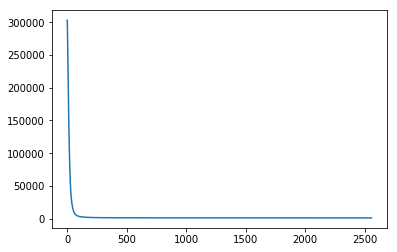

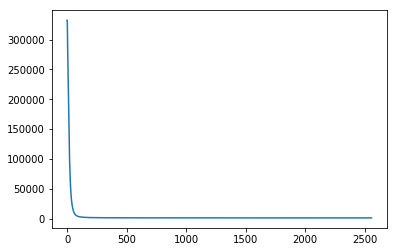

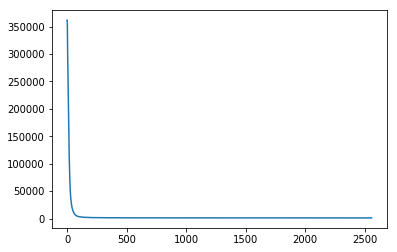

In [27]:
importlib.reload(stats)
params = {
    "x": "std-normalized",
    "name": img_name,
    "size": 250,
    "layers": 4,
    "iterations": 128,
    "blur": 5,
    "scale_decay": 0, # 0 means no scale decay
    "scale": 100000,
    "model": vgg,
    "hooks": hooks,
    "lr": 0.1,
}

meta_params = {
    "save_mode": "final" ,
    "example_feature_pyr": example_feature_pyr,
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Synthesizer(meta_params)

for s in [1000000]:
    for lr in [0.1]:
        for blur in [5, 4, 3]:
            params["lr"] = lr
            params["scale"] = s
            params["blur"] = blur
            params["id"] = identifier(params) 

            print(params["id"])

            _, losses = syn.synthesize(params)
            plt.figure()
            plt.plot(losses)